In [1617]:
from pathlib import Path
import geopandas as gpd
import matplotlib.pyplot as plt
import shapely as sp
import random
import cv2
import math
import numpy as np

In [1618]:
PATCH_SIZE = 512
EARTH_CIRCUFERENCE = 40075016.686

Get Bounds of Initial Dataset

In [1619]:
data_folder = Path("data/roadimages")
no_roads_folder = "1 _ No Roads"

file_paths = [file_path for file_path in data_folder.rglob("*") if file_path.is_file() and no_roads_folder not in file_path.parts]

file_names = [file_path.stem for file_path in data_folder.rglob("*") if file_path.is_file() and no_roads_folder not in file_path.parts]

file_parts = [file_name.split("_") for file_name in file_names]

sorted_file_parts = sorted(file_parts, key=lambda x: float(x[-1]))

min_lon = float(sorted_file_parts[0][-1])
max_lon = float(sorted_file_parts[-1][-1])
sorted_file_parts

sorted_file_parts = sorted(file_parts, key=lambda x: float(x[-2]))
min_lat = float(sorted_file_parts[0][-2])
max_lat = float(sorted_file_parts[-1][-2])
#sorted_file_parts


print("Minimum latitude:", min_lat)
print("Maximum latitude:", max_lat)

print("Minimum longitude:", min_lon)
print("Maximum longitude:", max_lon)

Minimum latitude: 14.501167
Maximum latitude: 14.69918
Minimum longitude: 120.963593
Maximum longitude: 121.105042


In [1620]:
shape = gpd.read_file("data/shapefiles/gis_osm_roads_free_1.shp")
dataset_area = gpd.read_file("data/shapefiles/dataset_area.shp")

dataset_area

,geometry
0,"POLYGON ((120.93428 14.47773, 121.1335 14.4739..."


In [1621]:
dataset_roads = shape[dataset_area['geometry'].item().contains(shape['geometry'])]

dataset_roads.count()

osm_id      142331
code        142331
fclass      142331
name         59119
ref           5241
oneway      142331
maxspeed    142331
layer       142331
bridge      142331
tunnel      142331
geometry    142331
dtype: int64

In [1622]:
dataset_roads.head()

,osm_id,code,fclass,name,ref,oneway,maxspeed,layer,bridge,tunnel,geometry
0,267,5152,cycleway,Maharlika Street,None,B,25,0,F,F,"LINESTRING (121.05212 14.6503, 121.05223 14.65..."
2,2667097,5113,primary,Taft Avenue,170,F,60,0,F,F,"LINESTRING (120.99671 14.55627, 120.9967 14.55..."
3,2667099,5113,primary,Lerma Street,170,F,50,0,F,F,"LINESTRING (120.98539 14.6046, 120.98545 14.60..."
4,2667105,5122,residential,E. Manaloto Street,None,B,0,0,F,F,"LINESTRING (120.9938 14.54125, 120.99497 14.54..."
5,2667111,5113,primary,Quezon Boulevard,170,F,60,0,F,F,"LINESTRING (120.98018 14.59292, 120.98002 14.5..."


<Axes: >

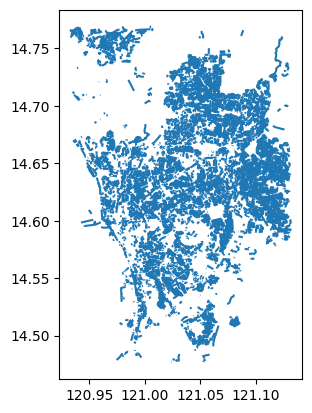

In [1623]:
dataset_roads[:10000].plot()

In [1624]:
dataset_roads['fclass'].unique()

array(['cycleway', 'primary', 'residential', 'secondary', 'tertiary',
       'motorway', 'trunk', 'primary_link', 'trunk_link', 'service',
       'unclassified', 'footway', 'steps', 'pedestrian', 'secondary_link',
       'motorway_link', 'tertiary_link', 'track', 'path', 'busway',
       'track_grade4', 'living_street', 'bridleway', 'track_grade5',
       'track_grade1'], dtype=object)

,osm_id,code,fclass,name,ref,oneway,maxspeed,layer,bridge,tunnel,geometry
711,4483587,5122,residential,Zodiac Street,None,B,0,0,F,F,"LINESTRING (121.03515 14.55605, 121.03552 14.5..."
1370,4940456,5122,residential,Recoletos Street,None,B,0,0,F,F,"LINESTRING (121.03432 14.55529, 121.03434 14.5..."
5901,14712757,5113,primary,Kalayaan Overpass,191,F,60,1,T,F,"LINESTRING (121.03568 14.55571, 121.03538 14.5..."
7659,22882909,5115,tertiary,Jupiter Street,None,B,30,0,F,F,"LINESTRING (121.03501 14.55593, 121.03494 14.5..."
23798,28535210,5115,tertiary,Zodiac Street,None,B,30,0,F,F,"LINESTRING (121.03501 14.55593, 121.03485 14.5..."
23859,28538743,5112,trunk,EDSA,1,F,60,0,F,F,"LINESTRING (121.03549 14.55549, 121.03522 14.5..."
23975,28574025,5132,trunk_link,None,None,F,0,1,T,F,"LINESTRING (121.03487 14.55522, 121.03495 14.5..."
29108,29213181,5112,trunk,EDSA,1,F,60,0,F,F,"LINESTRING (121.03508 14.55511, 121.0349 14.55..."
29110,29213301,5113,primary,Kalayaan Overpass,191,F,60,1,T,F,"LINESTRING (121.03447 14.55542, 121.03459 14.5..."
173565,146300437,5113,primary,Senator Gil J. Puyat Avenue,190,F,40,0,F,F,"LINESTRING (121.03507 14.55532, 121.03501 14.5..."


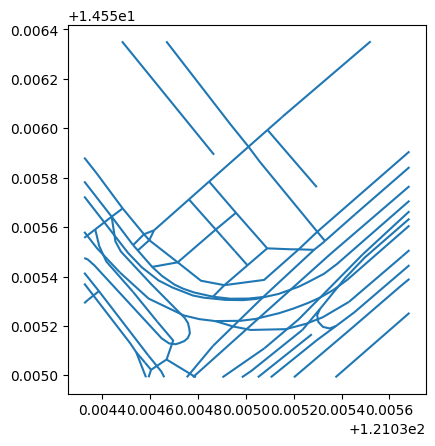

In [1625]:
centerx, centery = (121.035004, 14.555672)

offset = 0.00068
minx, miny, maxx, maxy = (centerx - offset, centery - offset, centerx + offset, centery + offset)
bbox = sp.geometry.box(minx, miny, maxx, maxy)

road_patch = dataset_roads.cx[minx:maxx, miny:maxy]
road_patch.loc[:, 'geometry'] = road_patch['geometry'].apply(lambda geom: geom.intersection(bbox))
road_patch = road_patch[~road_patch.is_empty]

road_patch.plot()

road_patch

data\roadmasks\39__14.551684_121.063843.png
Random patch path: data\roadimages\2 _ Roads with Occlusions\39__14.551684_121.063843.png


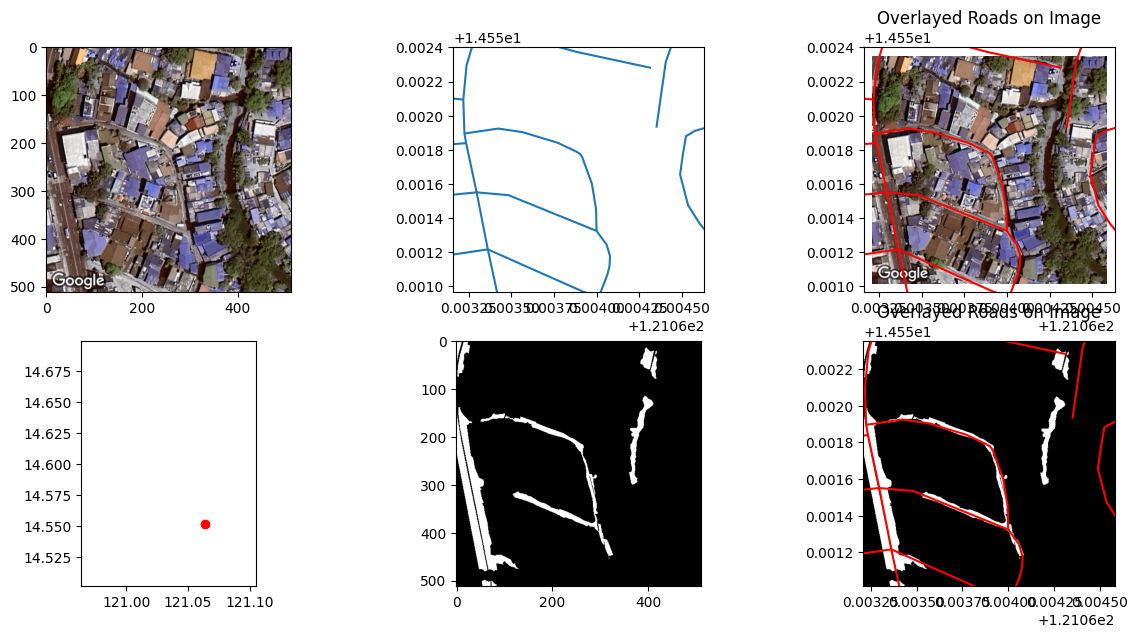

In [1806]:
#get file paths
#data\roadimages\3 _ Clear Regular Roads\57__14.557001_121.006165.png
DISPLAY_ALLOWANCE = 0.00005
random_patch_path = random.choice(file_paths)
folder_names = ["\\1 _ No Roads", "\\2 _ Roads with Occlusions", "\\3 _ Clear Regular Roads", "\\4 _ Wide Roads"]
mask_path = str(random_patch_path).replace("roadimages", "roadmasks")

#remove folder names from mask paths
for folder_name in folder_names:
    mask_path = mask_path.replace(folder_name, "")
print(mask_path)

#set patch size
lat_size = 0.0013364/2
long_size = 0.00137216/2
#right = increase lon offset; up = increase lat offset
lat_shift = 0.0000
lon_shift = -0.000053
random_patch_lat = float(random_patch_path.stem.split("_")[-2])
random_patch_lon = float(random_patch_path.stem.split("_")[-1])

#adjust linestring coordinates 
minx, miny, maxx, maxy = (random_patch_lon - long_size, random_patch_lat - lat_size, random_patch_lon + long_size, random_patch_lat + lat_size)
minx = minx - lon_shift
maxx = maxx - lon_shift
miny = miny - lat_shift
maxy = maxy - lat_shift
bbox = sp.geometry.box(minx, miny, maxx, maxy)

#remove roads outside of patch
random_patch_roads = dataset_roads.cx[minx:maxx, miny:maxy]

print("Random patch path:", random_patch_path)

image = cv2.imread(str(random_patch_path))
mask_image = cv2.imread(str(mask_path))

if random_patch_roads.empty:
    print("No roads found in the random patch.")
    plt.imshow(image)
else:
    fig, axes = plt.subplots(2, 3, figsize=(15, 7))
    axes[0][0].imshow(image)

    random_patch_roads.plot(ax=axes[0][1])

    axes[0][1].set_xlim(minx-DISPLAY_ALLOWANCE, maxx+DISPLAY_ALLOWANCE)
    axes[0][1].set_ylim(miny-DISPLAY_ALLOWANCE, maxy+DISPLAY_ALLOWANCE)
    axes[0][1].set_aspect('equal')

    axes[0][2].imshow(image, extent=[minx, maxx, miny, maxy])
    random_patch_roads.plot(ax=axes[0][2], color='red')
    axes[0][2].set_title("Overlayed Roads on Image")
    axes[0][2].set_xlim(minx-DISPLAY_ALLOWANCE, maxx+DISPLAY_ALLOWANCE)
    axes[0][2].set_ylim(miny-DISPLAY_ALLOWANCE, maxy+DISPLAY_ALLOWANCE)
    axes[0][2].set_aspect('equal')

    axes[1][0].scatter(random_patch_lon, random_patch_lat, color='red')
    axes[1][0].set_xlim(min_lon, max_lon)
    axes[1][0].set_ylim(min_lat, max_lat)
    axes[1][0].set_aspect('equal')
    
    axes[1][1].imshow(mask_image)

    axes[1][2].imshow(mask_image, extent=[minx, maxx, miny, maxy])
    random_patch_roads.plot(ax=axes[1][2], color='red')
    axes[1][2].set_title("Overlayed Roads on Image")
    axes[1][2].set_xlim(minx, maxx)
    axes[1][2].set_ylim(miny, maxy)
    axes[1][2].set_aspect('equal')

    plt.show()


<Axes: >

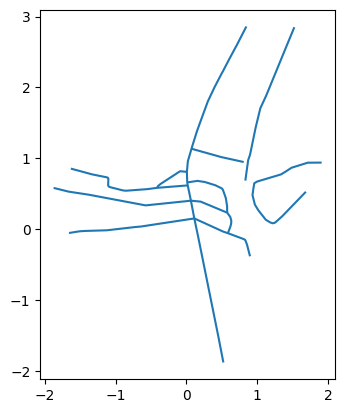

In [1807]:
#create scaled version of cropped linemap to fit mask
# Calculate scaling factors
# Function to scale geometries
def scale_geometry(geom, x_scale, y_scale):
    return sp.affinity.scale(geom, xfact=x_scale, yfact=y_scale, origin=(0,0))

def shift_geometry(geom, x_shift, y_shift):
    return sp.affinity.translate(geom, xoff=-x_shift, yoff=-y_shift)

# Create a copy of the GeoDataFrame and apply scaling to the copy
scaled_patch_roads = random_patch_roads.copy()
scaled_patch_roads["geometry"] = scaled_patch_roads["geometry"].apply(
    lambda geom: shift_geometry(geom, minx, miny)
)
scaled_patch_roads["geometry"] = scaled_patch_roads["geometry"].apply(
    lambda geom: scale_geometry(geom, 1/(maxx-minx), 1/(maxy-miny))
)
scaled_patch_roads.plot()

In [1808]:
roads_for_mask = scaled_patch_roads.copy()
roads_for_mask["geometry"] = roads_for_mask["geometry"].apply(
    lambda geom: scale_geometry(geom, 512, 512)
)

In [1809]:
def get_binary_mask_from_image(image):
    if len(image.shape) == 3:
        image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    _, image_mask = cv2.threshold(image, 127, 255, cv2.THRESH_BINARY)
    return np.flipud(image_mask)

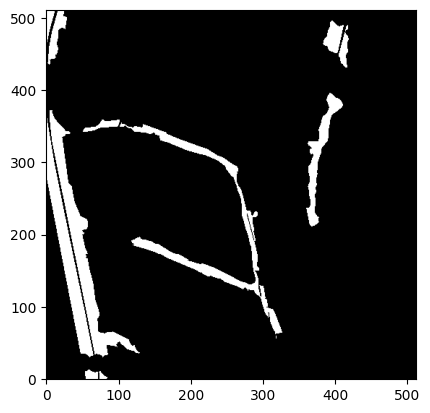

In [1810]:
image_mask = get_binary_mask_from_image(mask_image)
plt.imshow(image_mask, cmap='gray')
plt.gca().invert_yaxis()

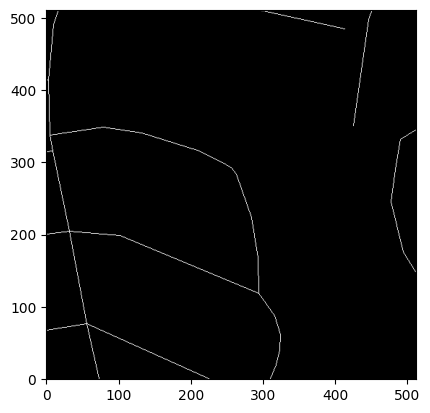

In [1811]:
def get_binary_mask_from_roads(scaled_patch_roads):
    road_mask = np.zeros((512, 512), dtype=np.uint8)
    for geom in scaled_patch_roads["geometry"]:
        if geom.is_empty:
            continue
        if isinstance(geom, sp.LineString):
            coords = np.array(geom.coords, dtype=np.int32)
            cv2.polylines(road_mask, [coords], isClosed=False, color=1, thickness=1)
    return road_mask

road_mask = get_binary_mask_from_roads(roads_for_mask)
plt.imshow(road_mask, cmap='gray')
plt.gca().invert_yaxis()


In [1812]:
def get_intersection(road_mask, image_mask):
    return np.sum((road_mask > 0) & (image_mask > 0))

In [1813]:
SEARCH_RANGE = 20
shifted_road_masks = [[None for _ in range(2 * SEARCH_RANGE + 1)] for _ in range(2 * SEARCH_RANGE + 1)]

for i in range(-SEARCH_RANGE, SEARCH_RANGE + 1):
    for j in range(-SEARCH_RANGE, SEARCH_RANGE + 1):
        road_copy = roads_for_mask.copy()
        road_copy["geometry"] = road_copy["geometry"].apply(
            lambda geom: shift_geometry(geom, i, j)
        )
        road_mask = get_binary_mask_from_roads(road_copy)
        shifted_road_masks[i + SEARCH_RANGE][j + SEARCH_RANGE] = road_mask

max_intersection = -1
max_i = -1
max_j = -1

# Iterate through the shifted_road_masks to find the greatest intersection
for i in range(2 * SEARCH_RANGE + 1):
    for j in range(2 * SEARCH_RANGE + 1):
        road_mask = shifted_road_masks[i][j]
        intersection = get_intersection(road_mask, image_mask)
        if intersection > max_intersection:
            max_intersection = intersection
            max_i = i
            max_j = j

best_road_mask = shifted_road_masks[max_i][max_j]

best_shift_values = (max_i - SEARCH_RANGE, max_j - SEARCH_RANGE)

print(f"Maximum intersection: {max_intersection}")
print(f"Shift coordinates: ({max_i - SEARCH_RANGE}, {max_j - SEARCH_RANGE})")

Maximum intersection: 1034
Shift coordinates: (6, -6)


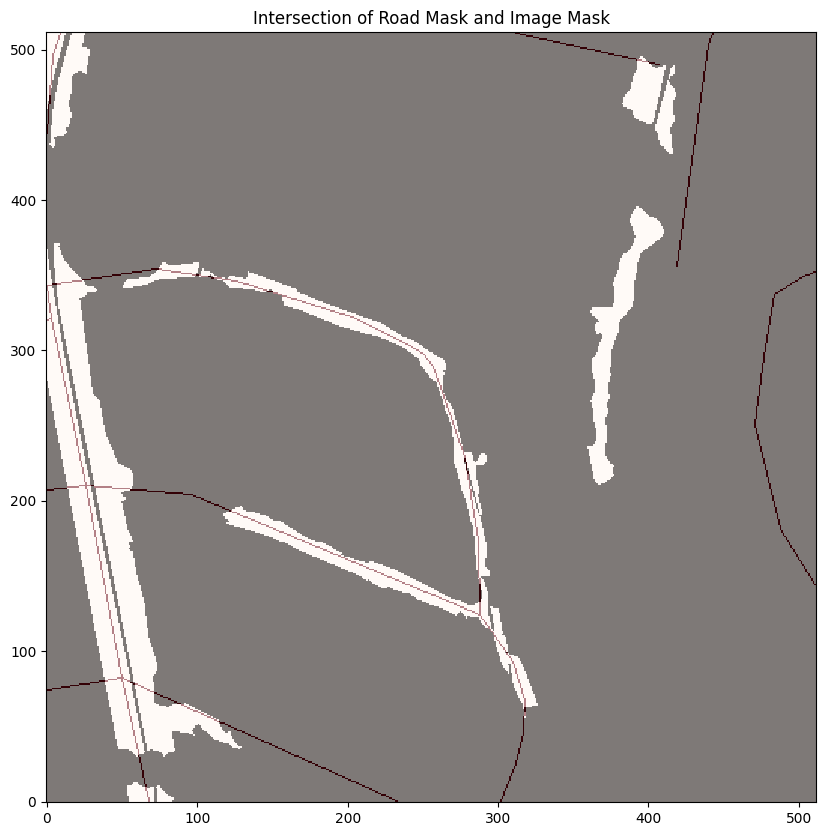

In [1814]:
plt.figure(figsize=(10, 10))
plt.imshow(image_mask, cmap='gray', interpolation='none')
plt.imshow(best_road_mask, cmap='Reds', alpha=0.5, interpolation='none')  # Overlay road_mask in red with transparency
plt.title("Intersection of Road Mask and Image Mask")
plt.gca().invert_yaxis()
plt.show()

In [1815]:
def interpolate_points(line, distance_interval):
    length = line.length
    num_points = math.ceil(length / distance_interval)
    distances = [i * distance_interval for i in range(num_points + 1)]
    points = [line.interpolate(distance) for distance in distances]
    #remove points that are out of bounds
    points = [point for point in points if point.x >= 0 and point.x < 512 and point.y >= 0 and point.y < 512]
    return points

In [1816]:
def perpendicular_line_eq(line, point):
    coords = list(line.coords)

    for i in range(len(coords) - 1):
        x1, y1 = coords[i]
        x2, y2 = coords[i + 1]
        segment = sp.LineString([(x1, y1), (x2, y2)])

        if segment.distance(point) <= 1e-7:  # Check if point is close to the segment
            # Compute original slope
            if x2 - x1 == 0:  # Vertical line -> perpendicular is horizontal
                return (0, point.y)  # y = constant (horizontal line)
            elif y2 - y1 == 0:  # Horizontal line -> perpendicular is vertical
                return (float('inf'), point.x)  # x = constant (vertical line)
            
            slope = (y2 - y1) / (x2 - x1)
            perp_slope = -1 / slope  # Perpendicular slope

            # Find the y-intercept using y = mx + b → b = y - mx
            x, y = point.x, point.y
            b = y - perp_slope * x

            return (perp_slope, b)  # Returns (slope, y-intercept)
    
    return None

In [1817]:
fitted_road_lines = roads_for_mask.copy()
fitted_road_lines["geometry"] = fitted_road_lines["geometry"].apply(
    lambda geom: shift_geometry(geom, best_shift_values[0], best_shift_values[1])
)

fitted_road_lines

,osm_id,code,fclass,name,ref,oneway,maxspeed,layer,bridge,tunnel,geometry
9570,23296776,5122,residential,23rd Avenue,None,B,0,0,F,F,"LINESTRING (-218.39552 304.02814, -211.64179 3..."
9571,23296777,5122,residential,24th Avenue,None,B,0,0,F,F,"LINESTRING (26.30597 210.96857, -301.23134 177..."
9572,23296778,5122,residential,25th Avenue,None,B,0,0,F,F,"LINESTRING (50.74627 82.81532, -336.1194 24.12..."
26794,28995806,5122,residential,23rd Avenue,None,B,0,0,F,F,"LINESTRING (3.35821 321.42173, -218.39552 304...."
47613,41112814,5141,service,A. Mariano Street,None,B,0,0,F,F,"LINESTRING (857.12687 275.44747, 686.90299 99...."
413975,344129327,5114,secondary,Jose P. Rizal Extension,None,B,40,0,F,F,"LINESTRING (260.89552 -958.23346, 256.56716 -9..."
479866,491363158,5122,residential,Narra Street,None,B,0,0,F,F,"LINESTRING (26.30597 210.96857, 96.04478 204.5..."
479867,491363160,5122,residential,Chico Street,None,B,0,0,F,F,"LINESTRING (-0.37313 343.02963, 73.39552 354.1..."
1301589,1071817715,5124,pedestrian,None,None,B,0,0,F,F,"LINESTRING (773.58209 1464.64831, 710.52239 13..."
1301874,1072181125,5122,residential,21st Avenue,None,B,0,0,F,F,"LINESTRING (407.79851 490.53038, 245.74627 526..."


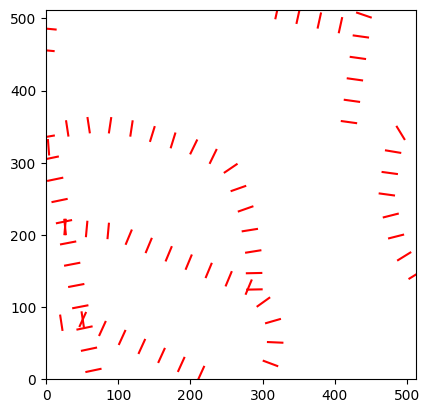

In [1818]:
SEARCH_INTERVAL = 30  # Distance between interpolated points
LINE_LENGTH = 20  # Total length of perpendicular lines

bbox = sp.geometry.box(0, 0, 512, 512)
point_line_eq = []
for road in fitted_road_lines['geometry'].items():
    geom = road[1]
    
    if isinstance(geom, sp.MultiLineString):
        for line in geom.geoms:
            points = interpolate_points(line, SEARCH_INTERVAL)
            for point in points:
                perp_result = perpendicular_line_eq(line, point)
                if perp_result is not None:
                    slope, intercept = perp_result
                    x, y = point.x, point.y

                    if slope == float('inf'):  # Vertical case
                        x1, x2 = x, x
                        y1, y2 = y - LINE_LENGTH / 2, y + LINE_LENGTH / 2
                        point_line_eq.append((x, y, slope, intercept))
                    else:
                        dx = LINE_LENGTH / (2 * (1 + slope ** 2) ** 0.5)
                        dy = slope * dx
                        x1, y1 = x - dx, y - dy
                        x2, y2 = x + dx, y + dy
                        point_line_eq.append((x, y, slope, intercept))

                    plt.plot([x1, x2], [y1, y2], color='red')

    elif isinstance(geom, sp.LineString):
        points = interpolate_points(geom, SEARCH_INTERVAL)
        for point in points:
            perp_result = perpendicular_line_eq(geom, point)
            if perp_result is not None:
                slope, intercept = perp_result
                x, y = point.x, point.y

                if slope == float('inf'):  # Vertical case
                    x1, x2 = x, x
                    y1, y2 = y - LINE_LENGTH / 2, y + LINE_LENGTH / 2
                    point_line_eq.append((x, y, slope, intercept))
                else:
                    dx = LINE_LENGTH / (2 * (1 + slope ** 2) ** 0.5)
                    dy = slope * dx
                    x1, y1 = x - dx, y - dy
                    x2, y2 = x + dx, y + dy
                    point_line_eq.append((x, y, slope, intercept))

                plt.plot([x1, x2], [y1, y2], color='red')

plt.xlim(0, 512)
plt.ylim(0, 512)
plt.gca().set_aspect('equal', adjustable='box')
plt.show()

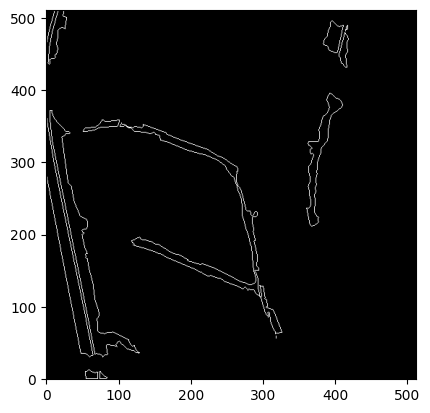

In [1819]:
def get_road_boundaries(image_mask):
    contours, _ = cv2.findContours(image_mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    road_boundary = np.zeros_like(image_mask)
    cv2.drawContours(road_boundary, contours, -1, 255, 1)
    return road_boundary

road_boundary = get_road_boundaries(image_mask)
plt.imshow(road_boundary, cmap='gray')
plt.gca().invert_yaxis()

Search Mode: outside


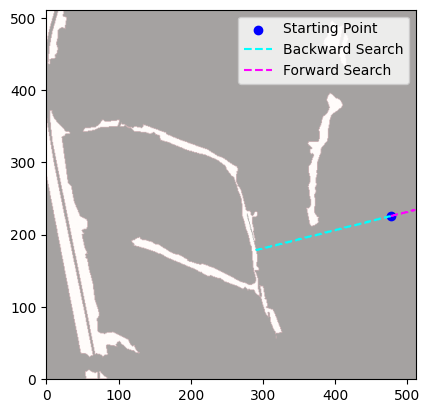

In [1897]:
def measure_nearest_road(point, slope, road_boundary, image_mask, plot=True):
    x, y = int(point[0]), int(point[1])
    height, width = road_boundary.shape

    # Check if the point is inside the road
    if image_mask[y, x] == 255:
        search_mode = "inside"
    else:
        search_mode = "outside"

    print("Search Mode:", search_mode)

    dist_backward, dist_forward = None, None
    points_forward = []
    points_backward = []

    if slope == float('inf'):  # **Vertical case**
        # Move upward (-y direction)
        for i in range(y, -1, -1):
            points_backward.append((x, i))
            if road_boundary[x, i] == 255:
                dist_backward = abs(y - i)
                if search_mode == "outside":
                    break

        # Move downward (+y direction)
        for i in range(y, height):
            points_forward.append((x, i))
            if road_boundary[x, i] == 255:
                if search_mode == "inside":
                    dist_forward = abs(i - y)
                elif search_mode == "outside" and dist_backward is not None:
                    dist_forward = abs(i - y)
                    break

    else:  # **Non-vertical case (diagonal/horizontal)**
        dx = 1 / (1 + slope ** 2) ** 0.5  # Normalize step size
        dy = slope * dx

        # Move backward (opposite to slope direction)
        x_b, y_b = x, y
        while 0 <= int(x_b) < width and 0 <= int(y_b) < height:
            points_backward.append((int(x_b), int(y_b)))
            if road_boundary[int(y_b), int(x_b)] == 255:
                dist_backward = ((x - x_b) ** 2 + (y - y_b) ** 2) ** 0.5
                if search_mode == "outside":
                    break
            x_b -= dx
            y_b -= dy

        # Move forward (along slope direction)
        x_f, y_f = x, y
        while 0 <= int(x_f) < width and 0 <= int(y_f) < height:
            points_forward.append((int(x_f), int(y_f)))
            if road_boundary[int(y_f), int(x_f)] == 255:
                if search_mode == "inside":
                    dist_forward = ((x - x_f) ** 2 + (y - y_f) ** 2) ** 0.5
                elif search_mode == "outside" and dist_backward is not None:
                    dist_forward = ((x - x_f) ** 2 + (y - y_f) ** 2) ** 0.5
                    break
            x_f += dx
            y_f += dy

    # **Plotting Section**
    if plot:
        plt.imshow(image_mask, cmap="gray", alpha=0.5)  # Show the road mask
        plt.imshow(road_boundary, cmap="Reds", alpha=0.3)  # Show road boundaries
        plt.scatter([x], [y], color="blue", label="Starting Point")  # Show start point
        if points_backward:
            plt.plot(*zip(*points_backward), color="cyan", linestyle="--", label="Backward Search")
        if points_forward:
            plt.plot(*zip(*points_forward), color="magenta", linestyle="--", label="Forward Search")
        plt.legend()
        plt.gca().invert_yaxis()
        plt.show()

    # Return total measured width if both sides found
    if dist_forward is not None and dist_backward is not None:
        return dist_forward + dist_backward
    return None  # No valid measurement found

# Test the function with a random point
instance = random.choice(point_line_eq)
point = instance[:2]
slope = instance[2]
measure_nearest_road(point, slope, road_boundary, image_mask)


In [1821]:
#calculate m per pixel: https://wiki.openstreetmap.org/wiki/Zoom_levels
def meters_per_pixel(lat):
    return EARTH_CIRCUFERENCE * abs(math.cos(math.radians(lat))) / (512 * (2 ** 18))

In [1822]:
avg_m_per_pixel = (meters_per_pixel(min_lat) + meters_per_pixel(max_lat)) / 2
(1/avg_m_per_pixel)

3.460925935231014